In [13]:
import torch
%matplotlib inline

import os
import gzip
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output
from datetime import datetime
from torchvision import datasets, transforms
from sklearn import metrics
from PIL import Image
from IPython.display import Image 



In [14]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

print(dev)

cuda:0


In [3]:
batch_size = 10

In [4]:
from torch.utils.data import Dataset, DataLoader
import os
import glob
from PIL import Image
import re


px_size = 60
py_size = 60

class DatasetMSE(Dataset):

    def __init__(self, image_dir, label_dir):
        self.colors = {
            0:torch.FloatTensor([255.0, 0.0, 0.0]),
            1:torch.FloatTensor([127.0, 0.0, 0.0]),
            2:torch.FloatTensor([255.0, 255.0, 0.0]),
            3:torch.FloatTensor([0.0, 255.0, 255.0]),
            4:torch.FloatTensor([0.0, 0.0, 255.0]),
            5:torch.FloatTensor([0.0, 255.0, 0.0])
            }
        
        self.transforms = []
        self.tf = transforms.Compose([transforms.ToTensor(), transforms.Resize((px_size,py_size))])
        self.label_imgs = torch.stack([self.get_labels(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/00*')]).to(dev)
        self.colour = torch.stack([self.get_colour(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/00*')]).to(dev)
        self.input_imgs = torch.stack([(self.tf((Image.open(file)))) for file in glob.glob(image_dir + '/00*')]).to(dev)
        self.add_colour()

    def __len__(self):
        return len(self.input_imgs)


    def __getitem__(self, idx):
        input_img, label_img = self.input_imgs[idx], self.label_imgs[idx]
        return input_img, label_img
    
    def col_sim(self, d):
        d = d*255
        a = torch.FloatTensor([torch.dist(d, self.colors[i]) for i in self.colors])
        return torch.argmin(a) 
    
    def view_shape(self):
        print(self.label_imgs.shape)
        print(self.input_imgs.shape)
    
    def get_labels(self, x):
        new_x = torch.zeros(6,px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[self.col_sim(new_d3[i][j])][i][j] = 1
                
        return new_x
        
    def get_colour(self, x):
        new_x = torch.zeros(px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[i][j] = self.col_sim(new_d3[i][j])
        return new_x
        
    def add_colour(self):
        print(self.input_imgs.shape)
        for i in range(self.input_imgs.shape[0]):
            print(i)
            self.input_imgs[i][0][self.colour[i] == 3] += 0.2
            self.input_imgs[i][1][self.colour[i] == 4] += 0.2
            self.input_imgs[i][2][self.colour[i] == 5] += 0.2
        self.input_imgs = self.input_imgs.clamp(0, 1)
            #new_x[1][y[i]==4] += 0.5
            #new_x[2][y[i]==5] += 0.5
            #new_x[2][y[i] == 0] += 0.5
            #new_x[1][y[i]==0] += 0.5
        
    
    def print_tensor(self, x):
        print(self.input_imgs[x])

In [32]:
dset_mse = DatasetMSE("Original","Labeled")
train_loader_MSE = torch.utils.data.DataLoader(dset_mse, shuffle=True, batch_size=batch_size)
#dset_mse.print_tensor(2)

torch.Size([9, 3, 60, 60])
0
1
2
3
4
5
6
7
8


In [3]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
def initial_seed(batch_size):
    return torch.zeros(batch_size, 3, px_size, py_size)

# Encode colour classes 1
def to_classes(d):
    d = d*255
    x = torch.zeros(6, d.shape[1], d.shape[2])
    # RED 255,0,0
    x[0][(d[0] > 220) & (d[1] < 20) & (d[2] < 20)] = 1
    # BROWN 127,0,0
    x[1][(d[0] > 60) & (d[0] < 200) & (d[1] < 60) & (d[2] < 60)] = 1
    # YELLOW 255, 255, 0
    x[2][(d[0] > 20) & (d[1] > 30) & (d[2] < 230)] = 1
    # LIGHT BLUE 0,255,255
    x[3][(d[0] < 100) & (d[1] > 100) & (d[2] > 100)] = 1
    # DARK BLUE 0,0,255
    x[4][(d[0] < 30) & (d[1] < 30) & (d[2] > 150)] = 1
    # GREEN 0,255,0
    x[5][(d[0] < 120) & (d[1] > 140) & (d[2] < 160)] = 1
    return torch.FloatTensor(x)

# Encode colour classes 2
def to_class(d):
    d = d*255
    x = torch.zeros(d.shape[1], d.shape[2])
    # RED 255,0,0
    #x[(d[0] > 180) & (d[1] < 60) & (d[2] < 60)] = 0
    # BROWN 127,0,0
    x[(d[0] > 60) & (d[0] < 200) & (d[1] < 60) & (d[2] < 60)] = 1
    # YELLOW 255, 255, 0
    x[(d[0] > 100) & (d[1] > 100) & (d[2] < 100)] = 2
    # LIGHT BLUE 0,255,255
    x[(d[0] < 60) & (d[1] > 180) & (d[2] > 180)] = 3
    # DARK BLUE 0,0,255
    x[(d[0] < 60) & (d[1] < 60) & (d[2] > 180)] = 4
    # GREEN 0,255,0
    x[(d[0] < 70) & (d[1] > 170) & (d[2] < 70)] = 5
    return torch.FloatTensor(x)

colors = {
    0:torch.FloatTensor([255.0, 0.0, 0.0]).to(dev),
    1:torch.FloatTensor([127.0, 0.0, 0.0]).to(dev),
    2:torch.FloatTensor([255.0, 255.0, 0.0]).to(dev),
    3:torch.FloatTensor([0.0, 255.0, 255.0]).to(dev),
    4:torch.FloatTensor([0.0, 0.0, 255.0]).to(dev),
    5:torch.FloatTensor([0.0, 255.0, 0.0]).to(dev)
    }
          
    
# Get RGB class channels
def get_rgb(x):
    return x.transpose(0,1)[3:9].transpose(0,1)

# Transform to display image
ts = transforms.ToPILImage()

# Get max class value and convert to RGB for the C classes
def max_rgb(x):
    newimg = torch.zeros(x.shape[0], px_size, px_size, 3).to(dev)
    for i in range(x.shape[0]):
        # RED 255, 0, 0
        newimg[i][torch.argmax(x[i],dim=0) == 0] = colors[0]
        # BROWN 127 0 0 
        newimg[i][torch.argmax(x[i],dim=0) == 1] = colors[1]
        # YELLOW 255, 255, 0
        newimg[i][torch.argmax(x[i],dim=0) == 2] = colors[2]
        # L BLUE 0, 255, 255
        newimg[i][torch.argmax(x[i],dim=0) == 3] = colors[3]
        # D BLUE 0, 0, 255
        newimg[i][torch.argmax(x[i],dim=0) == 4] = colors[4]
        # GREEN 0, 255, 0
        newimg[i][torch.argmax(x[i],dim=0) == 5] = colors[5]
    
    return (newimg/255.0).transpose(1,3).transpose(2,3)


def max_rgba(x):
    newimg = torch.zeros(px_size, px_size, 3)
    # RED 255, 0, 0
    newimg[torch.argmax(x,dim=0) == 0] = torch.FloatTensor([255.0, 0.0, 0.0])
    # BROWN 127 0 0 
    newimg[torch.argmax(x,dim=0) == 1] = torch.FloatTensor([127.0, 0.0, 0.0])
    # YELLOW 255, 255, 0
    newimg[torch.argmax(x,dim=0) == 2] = torch.FloatTensor([255.0, 255.0, 0.0])
    # L BLUE 0, 255, 255
    newimg[torch.argmax(x,dim=0) == 3] = torch.FloatTensor([0.0, 255.0, 255.0])
    # D BLUE 0, 0, 255
    newimg[torch.argmax(x,dim=0) == 4] = torch.FloatTensor([0.0, 0.0, 255.0])
    # GREEN 0, 255, 0
    newimg[torch.argmax(x,dim=0) == 5] = torch.FloatTensor([0.0, 255.0, 0.0])
    
    alpha = torch.max(x, dim=0).values.to(dev)
    #alpha = alpha/torch.max(alpha)
    newimg = (newimg/255.0).to(dev)
    newimg = torch.cat((newimg, alpha.view(px_size, px_size, 1)), dim=2)
    print(newimg.shape)
    return newimg.transpose(0,2).transpose(1,2)

# Flatten dimension
def loss_classes(x):
    y = torch.flatten(x,1,2)
    return y


In [4]:
batch_size = 10

In [5]:
# Cross Entropy

from torch.utils.data import Dataset, DataLoader
import os
import glob
from PIL import Image


px_size = 60
py_size = 60

class DatasetCE(Dataset):

    def __init__(self, image_dir, label_dir):
        self.colors = {
            0:torch.FloatTensor([255.0, 0.0, 0.0]),
            1:torch.FloatTensor([127.0, 0.0, 0.0]),
            2:torch.FloatTensor([255.0, 255.0, 0.0]),
            3:torch.FloatTensor([0.0, 255.0, 255.0]),
            4:torch.FloatTensor([0.0, 0.0, 255.0]),
            5:torch.FloatTensor([0.0, 255.0, 0.0])
            }
        
        self.transforms = []
        self.tf = transforms.Compose([transforms.ToTensor(), transforms.Resize((px_size,py_size))])
        self.input_imgs = torch.stack([self.tf((Image.open(file))) for file in glob.glob(image_dir + '/*')]).to(dev)
        self.label_imgs = torch.stack([self.get_labels(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/*')]).to(dev)
        #self.add_colour()
    
    def __len__(self):
        return len(self.input_imgs)


    def __getitem__(self, idx):
        input_img, label_img = self.input_imgs[idx], self.label_imgs[idx]
        return input_img, label_img
    
    def col_sim(self, d):
        d = d*255
        a = torch.FloatTensor([torch.dist(d, self.colors[i]) for i in self.colors])
        return torch.argmin(a) 
    
    def view_shape(self):
        print(self.label_imgs.shape)
        print(self.input_imgs.shape)
    
    # (3, x, y)
    def get_labels(self, x):
        new_x = torch.zeros(px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[i][j] = self.col_sim(new_d3[i][j])
        return new_x
    
    def add_colour(self):
        y = self.label_imgs.clone().detach()
        for i in range(self.input_imgs.shape[0]):
            self.input_imgs[i][0][y[i] == 3] += 0.3
            self.input_imgs[i][1][y[i] == 4] += 0.3
            self.input_imgs[i][2][y[i] == 5] += 0.3
        self.input_imgs = self.input_imgs.clamp(0, 1)     
        
    def get_imgs(self, x):
        new_x = torch.zeros(6,px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[self.col_sim(new_d3[i][j])][i][j] = 1
                
        return new_x

    

    

In [6]:
# Cross Entropy

dsetCE = DatasetCE("Original","Labeled")

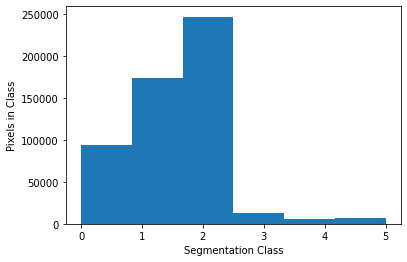

In [8]:
distn = dsetCE.label_imgs.clone().detach().flatten().int()
distn = np.asarray(distn.cpu())
plt.hist(distn, 6)
plt.xlabel("Segmentation Class")
plt.ylabel("Pixels in Class")
plt.savefig("pixeldistn.png", bbox_inches='tight')

In [7]:
train_DS, test_DS = torch.utils.data.random_split(dsetCE, [120, 30])
train_loader_CE = torch.utils.data.DataLoader(train_DS, shuffle=True, batch_size=batch_size)
test_loader_CE = torch.utils.data.DataLoader(test_DS, shuffle=True, batch_size=1)

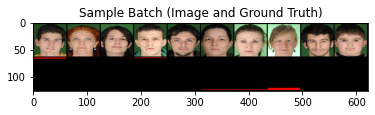

In [7]:
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, labels = next(iter(train_loader_CE))
# Make a grid from batch
out = torchvision.utils.make_grid(torch.cat((inputs, max_rgb(labels)),dim=0), nrow=batch_size)
imshow(out, title="Sample Batch (Image and Ground Truth)")


In [8]:
# Cellular automata class
class CAModel(nn.Module):

    def __init__(self, channel_n, fire_rate=0.5, device=torch.device("cpu")):
        super(CAModel, self).__init__()

        self.device = device
        self.channel_n = channel_n

        self.fire_rate = fire_rate
        self.to(self.device)
        
        self.conv1 = nn.Conv2d(45, 32, kernel_size=3, padding=1)
        #self.conv1a = nn.Conv2d(36,24, kernel_size=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 16, kernel_size=1)
        self.conv3 = nn.Conv2d(16, 6, kernel_size=1)
        
        self.pre_weight1 = nn.Conv2d(9, 9, kernel_size=3, padding=1)
        self.pre_weight2 = nn.Conv2d(9, 9, kernel_size=3, padding=1)
        self.pre_weight3 = nn.Conv2d(9, 9, kernel_size=3, padding=1)
        self.pre_weight4 = nn.Conv2d(9, 9, kernel_size=3, padding=1)
        
    def perceive(self, x, angle):

        def _perceive_with(x, weight):
            size = weight.shape[0]
            padding = (size-1)/2
            weight = weight.view(1,1,size,size).repeat(self.channel_n, 1, 1, 1)
            return F.conv2d(x, weight, padding=int(padding), groups=self.channel_n)
        
        # 3x3 sobel operators
        wa_1 = self.sobel_x
        wa_2 = self.sobel_y
        wa_3 = self.prewitt_x
        wa_4 = self.prewitt_y
        
        # Normalise these
        wa_1/=torch.sum(torch.abs(wa_1))
        wa_2/=torch.sum(torch.abs(wa_2))
        wa_3/=torch.sum(torch.abs(wa_3))
        wa_4/=torch.sum(torch.abs(wa_4))

        # Apply convolutions with the 4 of these filters
        y1 = _perceive_with(x, wa_1)
        y2 = _perceive_with(x, wa_2)
        y3 = _perceive_with(x, wa_1)
        y4 = _perceive_with(x, wa_2)

        # Concatenate: x (6 channels), 4 sobel filters (6 channels each), max pool (6 channels) = 36 total
        y = torch.cat((x,y1,y2,y3,y4),1)
        return y


    def forward(self, steps, x, last=False):
        x = torch.cat((x, torch.zeros(batch_size,6,px_size,px_size).to(dev)), dim=1)
        if last == True:
            epoch_history = []
            for i in range(steps):
                epoch_history.append(x.detach()[:,3:9,:])
                b1 = self.pre_weight1(x)
                b2 = self.pre_weight2(x)
                b3 = self.pre_weight3(x)
                b4 = self.pre_weight4(x)
                
                b = torch.cat((x, b1, b2, b3, b4), dim=1)
                bb = self.conv3(self.conv2(((self.relu(self.conv1(b))))))
                
                c = x.detach().clone()
                stochastic = torch.rand([bb.size(0),bb.size(1),bb.size(2),bb.size(3)])<self.fire_rate
                stochastic = stochastic.float().to(self.device)

                d = bb*stochastic
                e = c.transpose(0,1)[3:9].transpose(0,1) + d
                f = F.softmax(e, dim=1)
                
                x = torch.cat((c.transpose(0,1)[0:3].transpose(0,1),f),dim=1)
                
            return x, epoch_history
                
        else:
            for i in range(steps):
                b1 = self.pre_weight1(x)
                b2 = self.pre_weight2(x)
                b3 = self.pre_weight3(x)
                b4 = self.pre_weight4(x)
                
                b = torch.cat((x, b1, b2, b3, b4), dim=1)
                bb = self.conv3(self.conv2(((self.relu(self.conv1(b))))))
                
                c = x.detach().clone()
                stochastic = torch.rand([bb.size(0),bb.size(1),bb.size(2),bb.size(3)])<self.fire_rate
                stochastic = stochastic.float().to(self.device)

                d = bb*stochastic
                e = c.transpose(0,1)[3:9].transpose(0,1) + d
                f = F.softmax(e, dim=1)
                
                x = torch.cat((c.transpose(0,1)[0:3].transpose(0,1),f),dim=1)
            return x

In [26]:
# Load model, set loss function, optimizer and scheduler

model = CAModel(9,fire_rate=0.5,device=dev)
#model = torch.load('modelcollab1.pth')
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0008, betas=(0.9, 0.999))
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.999)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [30,60,90], 0.6)
#loss1 = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')

# RED, BROWN, YELLOW, LBLUE, DBLUE, GREEN
w = torch.FloatTensor([1.2,1, 1 , 11, 20, 11]).to(dev)
loss2 = torch.nn.CrossEntropyLoss(weight=w, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
#loss = torch.nn.KLDivLoss(size_average=None, reduce=None, reduction='mean', log_target=False)
#loss = FocalLoss()
loss_mse = []
loss_ce = []
history = []
epochs = 200

batch_size=10

In [12]:
# Print number of model parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

19780


In [112]:
mask1 = torch.zeros(1,6,55,55).to(dev)
mask2 = torch.zeros(1,6,55,55).to(dev)
k = mask1.shape[2]
for i in range(k):
    for j in range(k):
        mask1[:,:,i,j] = (i + j + 1) % 2
        mask2[:,:,i,j] = (i + j) % 2

In [ ]:
for epoch in range(epochs):
    i = 0
    last = False
    if epoch == epochs-1:
        last = True
    for batch in train_loader_MSE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)
            
        b = get_rgb(x)
        out = loss1(b,targets)
        print("Loss =", out)
        loss_mse.append(float(out))
        c = b.detach().clone()
        if (i % 5 == 0):
            print("EPOCH: ", epoch)
            display(ts(max_rgb(c)[0]))
            del c
            
        i += 1
        optimizer.zero_grad()
        out.backward()
        optimizer.step()

In [19]:
torch.save(model, 'modelMSE.pth')

In [ ]:
from array2gif import write_gif
eh = [(max_rgb(epoch_history[i])[1]*255).cpu().detach().numpy() for i in range(len(epoch_history))]
#eh = [(max_rgb(epoch_history[i][0])*255).cpu().detach().numpy() for i in range(len(epoch_history))]

write_gif(eh, 'final.gif', fps=1)
#eh[0].shape
#torch.stack(epoch_history)[0].shape

Loss = tensor(1.7920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  0


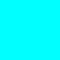

Learning rate:  0.0008
Loss = tensor(1.7912, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  0


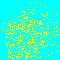

Learning rate:  0.0008
Loss = tensor(1.7859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7846, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7828, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  0


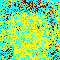

Learning rate:  0.0008
Loss = tensor(1.7788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  1


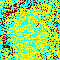

Learning rate:  0.0008
Loss = tensor(1.7745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7694, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  1


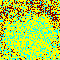

Learning rate:  0.0008
Loss = tensor(1.7568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7532, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7465, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7402, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  1


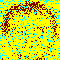

Learning rate:  0.0008
Loss = tensor(1.7325, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7339, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  2


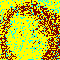

Learning rate:  0.0008
Loss = tensor(1.7305, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7290, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7365, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7211, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7145, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  2


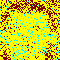

Learning rate:  0.0008
Loss = tensor(1.7223, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7086, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6989, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6894, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  2


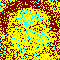

Learning rate:  0.0008
Loss = tensor(1.6890, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  3


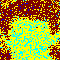

Learning rate:  0.0008
Loss = tensor(1.6924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6695, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  3


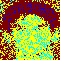

Learning rate:  0.0008
Loss = tensor(1.6756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6761, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  3


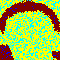

Learning rate:  0.0008
Loss = tensor(1.6639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  4


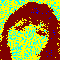

Learning rate:  0.0008
Loss = tensor(1.6658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  4


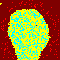

Learning rate:  0.0008
Loss = tensor(1.6683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6699, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6503, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  4


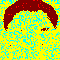

Learning rate:  0.0008
Loss = tensor(1.6673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  5


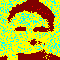

Learning rate:  0.0008
Loss = tensor(1.6641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6464, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6346, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6709, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  5


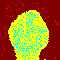

Learning rate:  0.0008
Loss = tensor(1.6467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6628, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  5


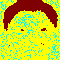

Learning rate:  0.0008
Loss = tensor(1.6692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  6


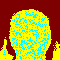

Learning rate:  0.0008
Loss = tensor(1.6650, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6493, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6242, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  6


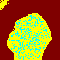

Learning rate:  0.0008
Loss = tensor(1.6579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6503, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6316, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  6


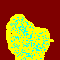

Learning rate:  0.0008
Loss = tensor(1.6800, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  7


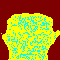

Learning rate:  0.0008
Loss = tensor(1.6548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6526, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6385, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  7


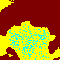

Learning rate:  0.0008
Loss = tensor(1.6386, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6434, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6340, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6339, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  7


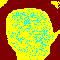

Learning rate:  0.0008
Loss = tensor(1.6787, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  8


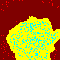

Learning rate:  0.0008
Loss = tensor(1.6367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6235, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  8


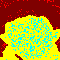

Learning rate:  0.0008
Loss = tensor(1.6437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6778, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6326, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  8


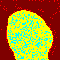

Learning rate:  0.0008
Loss = tensor(1.6677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  9


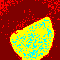

Learning rate:  0.0008
Loss = tensor(1.6382, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6301, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6563, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  9


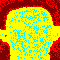

Learning rate:  0.0008
Loss = tensor(1.6359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6369, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6279, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  9


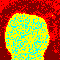

Learning rate:  0.0008
Loss = tensor(1.6646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6313, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  10


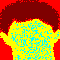

Learning rate:  0.0008
Loss = tensor(1.6523, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6339, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6213, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6286, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  10


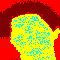

Learning rate:  0.0008
Loss = tensor(1.6226, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6318, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6311, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6281, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  10


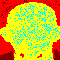

Learning rate:  0.0008
Loss = tensor(1.6377, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6150, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  11


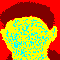

Learning rate:  0.0008
Loss = tensor(1.6518, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6042, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  11


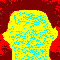

Learning rate:  0.0008
Loss = tensor(1.6266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6196, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  11


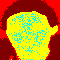

Learning rate:  0.0008
Loss = tensor(1.6292, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5807, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  12


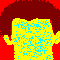

Learning rate:  0.0008
Loss = tensor(1.5744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6429, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6287, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  12


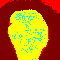

Learning rate:  0.0008
Loss = tensor(1.6127, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6046, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6144, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6598, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  12


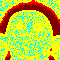

Learning rate:  0.0008
Loss = tensor(1.6396, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  13


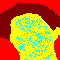

Learning rate:  0.0008
Loss = tensor(1.6107, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6184, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6235, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  13


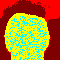

Learning rate:  0.0008
Loss = tensor(1.6403, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5892, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6093, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  13


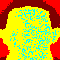

Learning rate:  0.0008
Loss = tensor(1.6476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  14


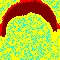

Learning rate:  0.0008
Loss = tensor(1.5938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6131, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6169, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6008, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5861, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  14


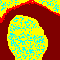

Learning rate:  0.0008
Loss = tensor(1.6188, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6136, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6103, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6057, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  14


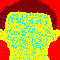

Learning rate:  0.0008
Loss = tensor(1.6345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5747, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  15


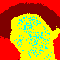

Learning rate:  0.0008
Loss = tensor(1.6118, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6111, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6086, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6106, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  15


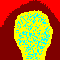

Learning rate:  0.0008
Loss = tensor(1.5899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6270, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6143, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6208, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6001, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  15


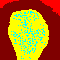

Learning rate:  0.0008
Loss = tensor(1.6075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5962, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  16


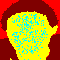

Learning rate:  0.0008
Loss = tensor(1.5685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6201, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6320, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  16


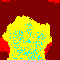

Learning rate:  0.0008
Loss = tensor(1.6051, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6304, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5747, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  16


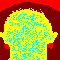

Learning rate:  0.0008
Loss = tensor(1.6124, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6314, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  17


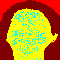

Learning rate:  0.0008
Loss = tensor(1.6191, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6253, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6277, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5807, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  17


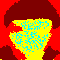

Learning rate:  0.0008
Loss = tensor(1.6380, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6052, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5929, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  17


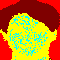

Learning rate:  0.0008
Loss = tensor(1.5889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  18


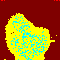

Learning rate:  0.0008
Loss = tensor(1.5933, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6207, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6055, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  18


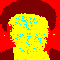

Learning rate:  0.0008
Loss = tensor(1.5841, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6143, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6176, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  18


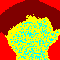

Learning rate:  0.0008
Loss = tensor(1.5912, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  19


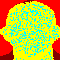

Learning rate:  0.0008
Loss = tensor(1.6001, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5925, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  19


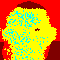

Learning rate:  0.0008
Loss = tensor(1.5769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5755, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  19


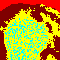

Learning rate:  0.0008
Loss = tensor(1.5954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5866, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  20


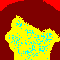

Learning rate:  0.0008
Loss = tensor(1.6076, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5594, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6053, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  20


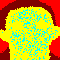

Learning rate:  0.0008
Loss = tensor(1.5692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5864, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  20


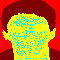

Learning rate:  0.0008
Loss = tensor(1.5831, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  21


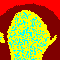

Learning rate:  0.0008
Loss = tensor(1.5946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  21


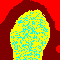

Learning rate:  0.0008
Loss = tensor(1.5664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  21


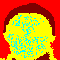

Learning rate:  0.0008
Loss = tensor(1.5657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6047, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  22


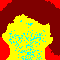

Learning rate:  0.0008
Loss = tensor(1.5761, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6004, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5742, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  22


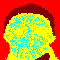

Learning rate:  0.0008
Loss = tensor(1.5786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5828, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5796, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  22


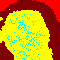

Learning rate:  0.0008
Loss = tensor(1.5899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  23


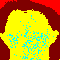

Learning rate:  0.0008
Loss = tensor(1.5824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5699, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  23


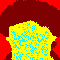

Learning rate:  0.0008
Loss = tensor(1.5808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5524, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  23


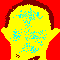

Learning rate:  0.0008
Loss = tensor(1.5917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  24


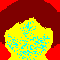

Learning rate:  0.0008
Loss = tensor(1.5771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  24


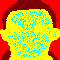

Learning rate:  0.0008
Loss = tensor(1.5852, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  24


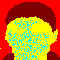

Learning rate:  0.0008
Loss = tensor(1.5596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  25


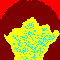

Learning rate:  0.0008
Loss = tensor(1.5563, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5607, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  25


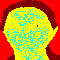

Learning rate:  0.0008
Loss = tensor(1.5859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5961, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  25


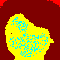

Learning rate:  0.0008
Loss = tensor(1.5821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  26


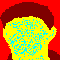

Learning rate:  0.0008
Loss = tensor(1.5900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5806, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5724, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  26


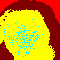

Learning rate:  0.0008
Loss = tensor(1.5546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  26


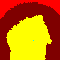

Learning rate:  0.0008
Loss = tensor(1.5881, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  27


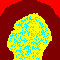

Learning rate:  0.0008
Loss = tensor(1.5702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  27


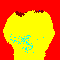

Learning rate:  0.0008
Loss = tensor(1.5751, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6021, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5631, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  27


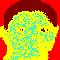

Learning rate:  0.0008
Loss = tensor(1.5641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  28


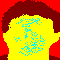

Learning rate:  0.0008
Loss = tensor(1.5771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5737, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5650, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5694, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  28


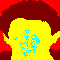

Learning rate:  0.0008
Loss = tensor(1.5648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5487, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5465, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  28


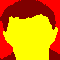

Learning rate:  0.0008
Loss = tensor(1.5813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  29


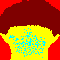

Learning rate:  0.0008
Loss = tensor(1.5915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  29


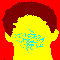

Learning rate:  0.0008
Loss = tensor(1.5756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5855, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  29


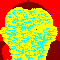

Learning rate:  0.0008
Loss = tensor(1.5928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  30


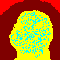

Learning rate:  0.00048
Loss = tensor(1.5834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5523, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5709, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5846, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5578, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  30


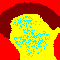

Learning rate:  0.00048
Loss = tensor(1.5634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5749, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5695, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  30


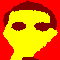

Learning rate:  0.00048
Loss = tensor(1.5484, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  31


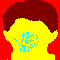

Learning rate:  0.00048
Loss = tensor(1.5782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5640, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  31


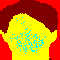

Learning rate:  0.00048
Loss = tensor(1.5605, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5812, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  31


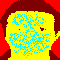

Learning rate:  0.00048
Loss = tensor(1.5758, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  32


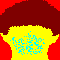

Learning rate:  0.00048
Loss = tensor(1.5744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5700, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  32


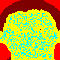

Learning rate:  0.00048
Loss = tensor(1.5826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5807, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  32


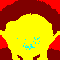

Learning rate:  0.00048
Loss = tensor(1.5693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  33


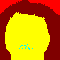

Learning rate:  0.00048
Loss = tensor(1.5621, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5577, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5811, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  33


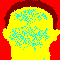

Learning rate:  0.00048
Loss = tensor(1.5746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5609, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  33


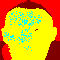

Learning rate:  0.00048
Loss = tensor(1.5849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5755, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  34


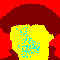

Learning rate:  0.00048
Loss = tensor(1.5534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5577, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5556, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  34


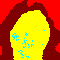

Learning rate:  0.00048
Loss = tensor(1.5774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  34


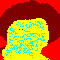

Learning rate:  0.00048
Loss = tensor(1.5682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5805, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  35


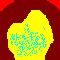

Learning rate:  0.00048
Loss = tensor(1.5679, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5503, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  35


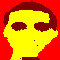

Learning rate:  0.00048
Loss = tensor(1.5670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5831, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5659, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  35


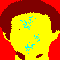

Learning rate:  0.00048
Loss = tensor(1.5888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  36


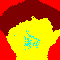

Learning rate:  0.00048
Loss = tensor(1.5640, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5551, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5661, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  36


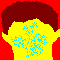

Learning rate:  0.00048
Loss = tensor(1.5642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5903, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  36


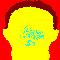

Learning rate:  0.00048
Loss = tensor(1.5782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  37


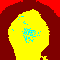

Learning rate:  0.00048
Loss = tensor(1.5828, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  37


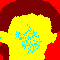

Learning rate:  0.00048
Loss = tensor(1.5638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5632, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  37


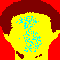

Learning rate:  0.00048
Loss = tensor(1.5727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  38


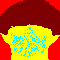

Learning rate:  0.00048
Loss = tensor(1.5675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5551, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  38


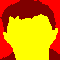

Learning rate:  0.00048
Loss = tensor(1.5575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5674, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5632, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  38


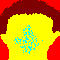

Learning rate:  0.00048
Loss = tensor(1.5917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  39


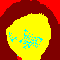

Learning rate:  0.00048
Loss = tensor(1.5761, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5796, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5612, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  39


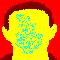

Learning rate:  0.00048
Loss = tensor(1.5418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5725, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  39


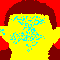

Learning rate:  0.00048
Loss = tensor(1.5828, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6043, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  40


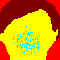

Learning rate:  0.00048
Loss = tensor(1.5576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5527, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  40


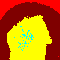

Learning rate:  0.00048
Loss = tensor(1.5536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5600, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5640, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  40


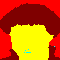

Learning rate:  0.00048
Loss = tensor(1.5648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  41


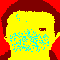

Learning rate:  0.00048
Loss = tensor(1.5614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5509, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  41


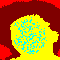

Learning rate:  0.00048
Loss = tensor(1.5606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5709, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  41


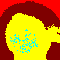

Learning rate:  0.00048
Loss = tensor(1.5829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  42


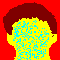

Learning rate:  0.00048
Loss = tensor(1.5480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5979, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  42


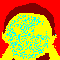

Learning rate:  0.00048
Loss = tensor(1.5878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5725, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5527, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5594, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  42


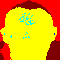

Learning rate:  0.00048
Loss = tensor(1.6014, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  43


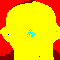

Learning rate:  0.00048
Loss = tensor(1.5939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5757, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6059, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5757, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  43


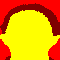

Learning rate:  0.00048
Loss = tensor(1.5636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  43


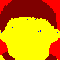

Learning rate:  0.00048
Loss = tensor(1.5781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  44


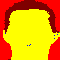

Learning rate:  0.00048
Loss = tensor(1.5849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5933, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5747, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  44


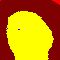

Learning rate:  0.00048
Loss = tensor(1.5573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5979, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  44


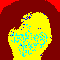

Learning rate:  0.00048
Loss = tensor(1.5985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5486, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  45


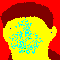

Learning rate:  0.00048
Loss = tensor(1.5659, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  45


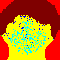

Learning rate:  0.00048
Loss = tensor(1.5522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5894, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  45


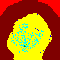

Learning rate:  0.00048
Loss = tensor(1.5547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  46


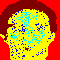

Learning rate:  0.00048
Loss = tensor(1.5616, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5463, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  46


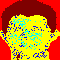

Learning rate:  0.00048
Loss = tensor(1.5566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5762, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5591, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  46


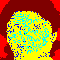

Learning rate:  0.00048
Loss = tensor(1.5565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  47


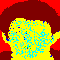

Learning rate:  0.00048
Loss = tensor(1.5506, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5527, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  47


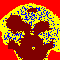

Learning rate:  0.00048
Loss = tensor(1.5597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5353, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  47


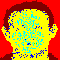

Learning rate:  0.00048
Loss = tensor(1.5481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  48


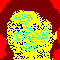

Learning rate:  0.00048
Loss = tensor(1.5408, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5587, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5406, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5387, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  48


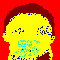

Learning rate:  0.00048
Loss = tensor(1.5715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5713, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5699, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5299, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  48


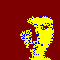

Learning rate:  0.00048
Loss = tensor(1.5669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  49


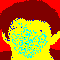

Learning rate:  0.00048
Loss = tensor(1.5430, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  49


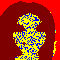

Learning rate:  0.00048
Loss = tensor(1.5462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  49


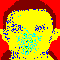

Learning rate:  0.00048
Loss = tensor(1.5530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  50


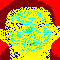

Learning rate:  0.00048
Loss = tensor(1.5507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5328, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5506, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  50


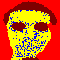

Learning rate:  0.00048
Loss = tensor(1.5624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  50


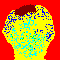

Learning rate:  0.00048
Loss = tensor(1.5494, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  51


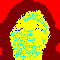

Learning rate:  0.00048
Loss = tensor(1.5572, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5812, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  51


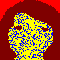

Learning rate:  0.00048
Loss = tensor(1.5703, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5380, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  51


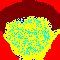

Learning rate:  0.00048
Loss = tensor(1.5721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  52


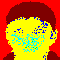

Learning rate:  0.00048
Loss = tensor(1.5533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5499, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  52


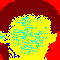

Learning rate:  0.00048
Loss = tensor(1.5797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5509, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5463, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5667, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  52


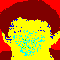

Learning rate:  0.00048
Loss = tensor(1.5620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5749, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  53


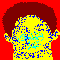

Learning rate:  0.00048
Loss = tensor(1.5569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5600, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  53


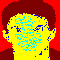

Learning rate:  0.00048
Loss = tensor(1.5423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  53


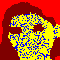

Learning rate:  0.00048
Loss = tensor(1.5489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5430, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  54


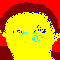

Learning rate:  0.00048
Loss = tensor(1.5403, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5349, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5464, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  54


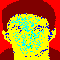

Learning rate:  0.00048
Loss = tensor(1.5536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5408, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5499, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  54


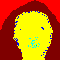

Learning rate:  0.00048
Loss = tensor(1.5536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5484, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  55


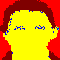

Learning rate:  0.00048
Loss = tensor(1.5549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5398, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  55


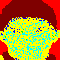

Learning rate:  0.00048
Loss = tensor(1.5860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  55


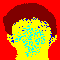

Learning rate:  0.00048
Loss = tensor(1.5418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  56


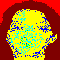

Learning rate:  0.00048
Loss = tensor(1.5439, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  56


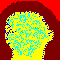

Learning rate:  0.00048
Loss = tensor(1.5791, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5429, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5470, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  56


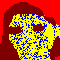

Learning rate:  0.00048
Loss = tensor(1.5407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  57


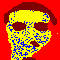

Learning rate:  0.00048
Loss = tensor(1.5839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5364, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5486, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  57


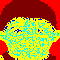

Learning rate:  0.00048
Loss = tensor(1.5443, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5577, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5551, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  57


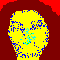

Learning rate:  0.00048
Loss = tensor(1.5645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  58


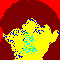

Learning rate:  0.00048
Loss = tensor(1.5464, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5389, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5354, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  58


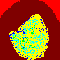

Learning rate:  0.00048
Loss = tensor(1.5504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5498, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5419, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5384, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  58


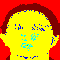

Learning rate:  0.00048
Loss = tensor(1.5936, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5800, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  59


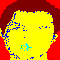

Learning rate:  0.00048
Loss = tensor(1.5530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  59


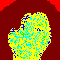

Learning rate:  0.00048
Loss = tensor(1.5161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5452, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5739, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  59


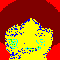

Learning rate:  0.00048
Loss = tensor(1.5436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5426, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  60


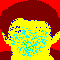

Learning rate:  0.000288
Loss = tensor(1.5634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5482, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  60


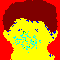

Learning rate:  0.000288
Loss = tensor(1.5394, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5371, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  60


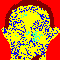

Learning rate:  0.000288
Loss = tensor(1.5647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5490, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  61


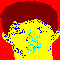

Learning rate:  0.000288
Loss = tensor(1.5260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5255, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  61


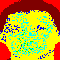

Learning rate:  0.000288
Loss = tensor(1.5367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  61


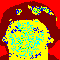

Learning rate:  0.000288
Loss = tensor(1.5462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  62


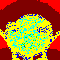

Learning rate:  0.000288
Loss = tensor(1.5793, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5289, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  62


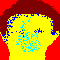

Learning rate:  0.000288
Loss = tensor(1.5624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5216, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5264, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5365, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  62


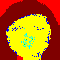

Learning rate:  0.000288
Loss = tensor(1.5353, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5751, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  63


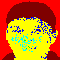

Learning rate:  0.000288
Loss = tensor(1.5309, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  63


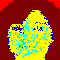

Learning rate:  0.000288
Loss = tensor(1.5272, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  63


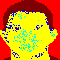

Learning rate:  0.000288
Loss = tensor(1.5414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5346, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  64


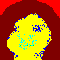

Learning rate:  0.000288
Loss = tensor(1.5348, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5524, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5300, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5452, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  64


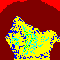

Learning rate:  0.000288
Loss = tensor(1.5379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5452, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5841, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5224, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  64


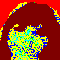

Learning rate:  0.000288
Loss = tensor(1.5385, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  65


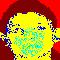

Learning rate:  0.000288
Loss = tensor(1.5638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5775, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5404, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  65


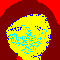

Learning rate:  0.000288
Loss = tensor(1.5481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5385, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5464, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  65


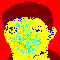

Learning rate:  0.000288
Loss = tensor(1.5315, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  66


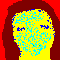

Learning rate:  0.000288
Loss = tensor(1.5241, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5162, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  66


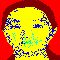

Learning rate:  0.000288
Loss = tensor(1.5545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5307, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5215, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  66


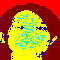

Learning rate:  0.000288
Loss = tensor(1.5395, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  67


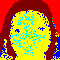

Learning rate:  0.000288
Loss = tensor(1.5411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5469, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  67


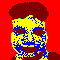

Learning rate:  0.000288
Loss = tensor(1.5482, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5312, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5615, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5234, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  67


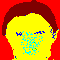

Learning rate:  0.000288
Loss = tensor(1.5289, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5443, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  68


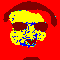

Learning rate:  0.000288
Loss = tensor(1.5551, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5318, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5169, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  68


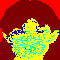

Learning rate:  0.000288
Loss = tensor(1.5326, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5148, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5168, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5195, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5393, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  68


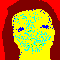

Learning rate:  0.000288
Loss = tensor(1.5239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5331, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  69


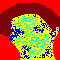

Learning rate:  0.000288
Loss = tensor(1.5344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5282, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5306, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5393, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  69


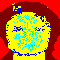

Learning rate:  0.000288
Loss = tensor(1.5035, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5256, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5043, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5309, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  69


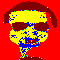

Learning rate:  0.000288
Loss = tensor(1.5675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5145, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  70


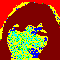

Learning rate:  0.000288
Loss = tensor(1.5423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5185, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  70


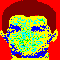

Learning rate:  0.000288
Loss = tensor(1.5340, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5261, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  70


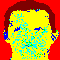

Learning rate:  0.000288
Loss = tensor(1.5361, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  71


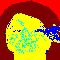

Learning rate:  0.000288
Loss = tensor(1.5457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4983, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5093, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  71


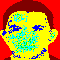

Learning rate:  0.000288
Loss = tensor(1.4919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  71


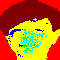

Learning rate:  0.000288
Loss = tensor(1.4961, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5294, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  72


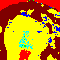

Learning rate:  0.000288
Loss = tensor(1.4955, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5168, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5273, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4956, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  72


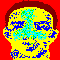

Learning rate:  0.000288
Loss = tensor(1.5156, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5220, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  72


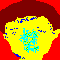

Learning rate:  0.000288
Loss = tensor(1.5039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  73


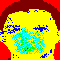

Learning rate:  0.000288
Loss = tensor(1.5039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4892, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  73


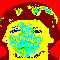

Learning rate:  0.000288
Loss = tensor(1.5140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5040, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5371, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  73


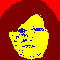

Learning rate:  0.000288
Loss = tensor(1.5575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  74


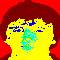

Learning rate:  0.000288
Loss = tensor(1.4918, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5130, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5204, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5306, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  74


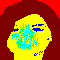

Learning rate:  0.000288
Loss = tensor(1.4873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5059, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5048, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5026, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  74


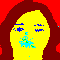

Learning rate:  0.000288
Loss = tensor(1.5252, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  75


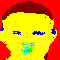

Learning rate:  0.000288
Loss = tensor(1.4578, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5304, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4891, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  75


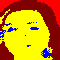

Learning rate:  0.000288
Loss = tensor(1.4954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4955, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5228, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4891, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  75


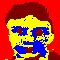

Learning rate:  0.000288
Loss = tensor(1.5201, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5029, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  76


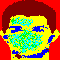

Learning rate:  0.000288
Loss = tensor(1.4942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5178, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  76


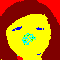

Learning rate:  0.000288
Loss = tensor(1.4811, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5176, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5065, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  76


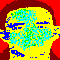

Learning rate:  0.000288
Loss = tensor(1.4778, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5035, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  77


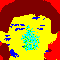

Learning rate:  0.000288
Loss = tensor(1.5289, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4806, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  77


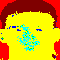

Learning rate:  0.000288
Loss = tensor(1.4914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4759, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4979, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  77


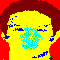

Learning rate:  0.000288
Loss = tensor(1.4810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5068, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  78


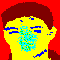

Learning rate:  0.000288
Loss = tensor(1.4799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4699, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  78


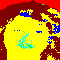

Learning rate:  0.000288
Loss = tensor(1.4856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4979, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  78


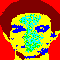

Learning rate:  0.000288
Loss = tensor(1.5163, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  79


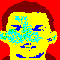

Learning rate:  0.000288
Loss = tensor(1.5062, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5215, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5170, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  79


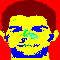

Learning rate:  0.000288
Loss = tensor(1.4833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4852, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4997, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  79


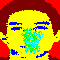

Learning rate:  0.000288
Loss = tensor(1.4769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  80


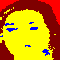

Learning rate:  0.000288
Loss = tensor(1.5212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4852, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5392, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  80


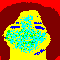

Learning rate:  0.000288
Loss = tensor(1.4753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  80


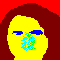

Learning rate:  0.000288
Loss = tensor(1.4898, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  81


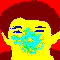

Learning rate:  0.000288
Loss = tensor(1.4981, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  81


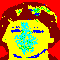

Learning rate:  0.000288
Loss = tensor(1.4911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4947, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  81


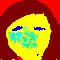

Learning rate:  0.000288
Loss = tensor(1.4974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  82


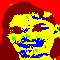

Learning rate:  0.000288
Loss = tensor(1.4756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4368, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  82


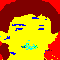

Learning rate:  0.000288
Loss = tensor(1.4951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4844, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4846, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4742, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5000, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  82


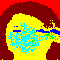

Learning rate:  0.000288
Loss = tensor(1.4750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  83


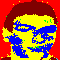

Learning rate:  0.000288
Loss = tensor(1.4668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4957, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  83


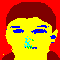

Learning rate:  0.000288
Loss = tensor(1.4776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5077, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4918, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  83


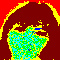

Learning rate:  0.000288
Loss = tensor(1.4516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4631, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  84


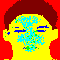

Learning rate:  0.000288
Loss = tensor(1.4987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5074, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4837, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  84


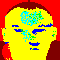

Learning rate:  0.000288
Loss = tensor(1.4439, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5121, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4595, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5007, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  84


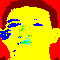

Learning rate:  0.000288
Loss = tensor(1.4763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4310, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  85


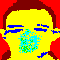

Learning rate:  0.000288
Loss = tensor(1.4606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5046, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5078, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  85


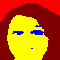

Learning rate:  0.000288
Loss = tensor(1.5351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5275, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4512, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  85


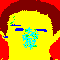

Learning rate:  0.000288
Loss = tensor(1.4932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  86


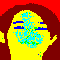

Learning rate:  0.000288
Loss = tensor(1.4975, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  86


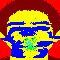

Learning rate:  0.000288
Loss = tensor(1.4772, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4713, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5012, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4976, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4630, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  86


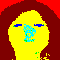

Learning rate:  0.000288
Loss = tensor(1.4562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4832, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  87


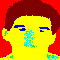

Learning rate:  0.000288
Loss = tensor(1.4837, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4587, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4816, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4410, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  87


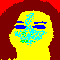

Learning rate:  0.000288
Loss = tensor(1.4414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4983, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  87


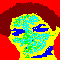

Learning rate:  0.000288
Loss = tensor(1.4624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  88


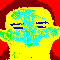

Learning rate:  0.000288
Loss = tensor(1.4511, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5114, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4280, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  88


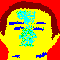

Learning rate:  0.000288
Loss = tensor(1.5253, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5154, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  88


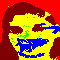

Learning rate:  0.000288
Loss = tensor(1.4792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  89


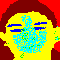

Learning rate:  0.000288
Loss = tensor(1.4776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4319, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4724, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  89


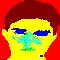

Learning rate:  0.000288
Loss = tensor(1.4681, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4392, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4331, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  89


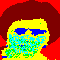

Learning rate:  0.000288
Loss = tensor(1.4913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4492, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  90


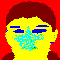

Learning rate:  0.0001728
Loss = tensor(1.4384, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4287, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4368, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  90


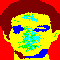

Learning rate:  0.0001728
Loss = tensor(1.4666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5370, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4315, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4264, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  90


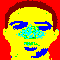

Learning rate:  0.0001728
Loss = tensor(1.4829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4479, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  91


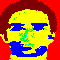

Learning rate:  0.0001728
Loss = tensor(1.4357, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4305, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4712, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  91


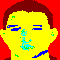

Learning rate:  0.0001728
Loss = tensor(1.4291, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  91


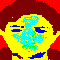

Learning rate:  0.0001728
Loss = tensor(1.4675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  92


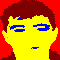

Learning rate:  0.0001728
Loss = tensor(1.4868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4396, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4430, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  92


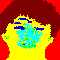

Learning rate:  0.0001728
Loss = tensor(1.4951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4406, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4659, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  92


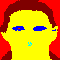

Learning rate:  0.0001728
Loss = tensor(1.4418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4320, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  93


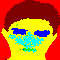

Learning rate:  0.0001728
Loss = tensor(1.4459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4365, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5006, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  93


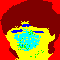

Learning rate:  0.0001728
Loss = tensor(1.4169, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  93


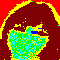

Learning rate:  0.0001728
Loss = tensor(1.4404, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4226, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  94


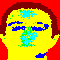

Learning rate:  0.0001728
Loss = tensor(1.4652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4074, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4511, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  94


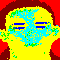

Learning rate:  0.0001728
Loss = tensor(1.4672, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4529, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  94


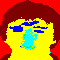

Learning rate:  0.0001728
Loss = tensor(1.4955, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  95


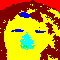

Learning rate:  0.0001728
Loss = tensor(1.4911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4234, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4313, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  95


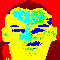

Learning rate:  0.0001728
Loss = tensor(1.4465, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4628, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  95


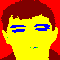

Learning rate:  0.0001728
Loss = tensor(1.4397, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  96


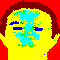

Learning rate:  0.0001728
Loss = tensor(1.4556, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4177, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4995, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  96


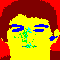

Learning rate:  0.0001728
Loss = tensor(1.4416, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4470, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4460, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  96


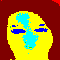

Learning rate:  0.0001728
Loss = tensor(1.4455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4336, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  97


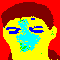

Learning rate:  0.0001728
Loss = tensor(1.4325, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4179, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4307, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  97


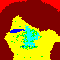

Learning rate:  0.0001728
Loss = tensor(1.4959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4352, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4214, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  97


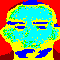

Learning rate:  0.0001728
Loss = tensor(1.4170, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4701, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  98


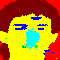

Learning rate:  0.0001728
Loss = tensor(1.4683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  98


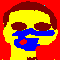

Learning rate:  0.0001728
Loss = tensor(1.4335, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4169, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  98


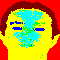

Learning rate:  0.0001728
Loss = tensor(1.4433, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4410, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  99


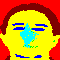

Learning rate:  0.0001728
Loss = tensor(1.4100, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4453, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4421, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  99


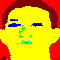

Learning rate:  0.0001728
Loss = tensor(1.4451, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5127, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4529, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  99


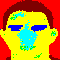

Learning rate:  0.0001728
Loss = tensor(1.4283, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4336, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  100


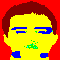

Learning rate:  0.0001728
Loss = tensor(1.4580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4304, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4202, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4330, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  100


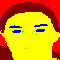

Learning rate:  0.0001728
Loss = tensor(1.4604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4982, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  100


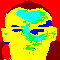

Learning rate:  0.0001728
Loss = tensor(1.4256, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  101


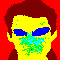

Learning rate:  0.0001728
Loss = tensor(1.4252, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4396, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4146, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4328, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  101


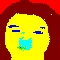

Learning rate:  0.0001728
Loss = tensor(1.4066, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4681, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4097, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  101


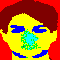

Learning rate:  0.0001728
Loss = tensor(1.4460, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4615, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  102


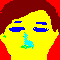

Learning rate:  0.0001728
Loss = tensor(1.4436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4415, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4253, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  102


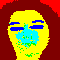

Learning rate:  0.0001728
Loss = tensor(1.4445, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4261, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4163, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  102


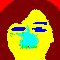

Learning rate:  0.0001728
Loss = tensor(1.4581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4168, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  103


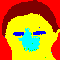

Learning rate:  0.0001728
Loss = tensor(1.4591, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4290, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  103


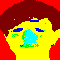

Learning rate:  0.0001728
Loss = tensor(1.4273, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4567, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  103


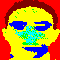

Learning rate:  0.0001728
Loss = tensor(1.4537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5028, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  104


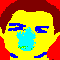

Learning rate:  0.0001728
Loss = tensor(1.4072, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4204, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4216, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  104


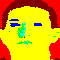

Learning rate:  0.0001728
Loss = tensor(1.4820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4224, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4067, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4811, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  104


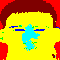

Learning rate:  0.0001728
Loss = tensor(1.4158, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  105


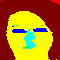

Learning rate:  0.0001728
Loss = tensor(1.4449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4178, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4115, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4303, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  105


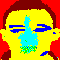

Learning rate:  0.0001728
Loss = tensor(1.4653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4275, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4518, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  105


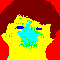

Learning rate:  0.0001728
Loss = tensor(1.4219, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  106


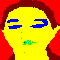

Learning rate:  0.0001728
Loss = tensor(1.4794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4402, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  106


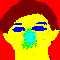

Learning rate:  0.0001728
Loss = tensor(1.4674, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4612, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4640, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  106


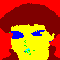

Learning rate:  0.0001728
Loss = tensor(1.4443, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4353, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  107


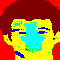

Learning rate:  0.0001728
Loss = tensor(1.4419, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4509, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4217, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  107


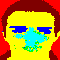

Learning rate:  0.0001728
Loss = tensor(1.4518, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4428, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4049, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4396, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  107


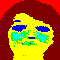

Learning rate:  0.0001728
Loss = tensor(1.4132, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4223, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  108


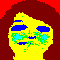

Learning rate:  0.0001728
Loss = tensor(1.4395, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4343, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4357, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  108


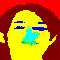

Learning rate:  0.0001728
Loss = tensor(1.4129, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4694, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  108


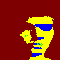

Learning rate:  0.0001728
Loss = tensor(1.4446, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4100, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  109


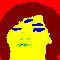

Learning rate:  0.0001728
Loss = tensor(1.4910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4484, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4234, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4117, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  109


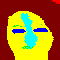

Learning rate:  0.0001728
Loss = tensor(1.4413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4326, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4119, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  109


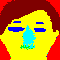

Learning rate:  0.0001728
Loss = tensor(1.4972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  110


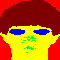

Learning rate:  0.0001728
Loss = tensor(1.4336, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4342, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  110


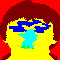

Learning rate:  0.0001728
Loss = tensor(1.4494, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5138, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4134, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4171, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  110


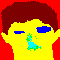

Learning rate:  0.0001728
Loss = tensor(1.3801, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  111


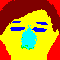

Learning rate:  0.0001728
Loss = tensor(1.4054, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4201, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4219, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  111


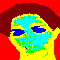

Learning rate:  0.0001728
Loss = tensor(1.4419, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4277, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  111


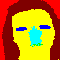

Learning rate:  0.0001728
Loss = tensor(1.5130, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4758, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  112


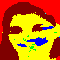

Learning rate:  0.0001728
Loss = tensor(1.4214, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4259, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3890, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4249, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  112


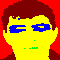

Learning rate:  0.0001728
Loss = tensor(1.4034, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4387, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  112


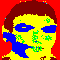

Learning rate:  0.0001728
Loss = tensor(1.4214, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  113


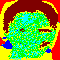

Learning rate:  0.0001728
Loss = tensor(1.4063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4060, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4287, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4139, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  113


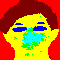

Learning rate:  0.0001728
Loss = tensor(1.4229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  113


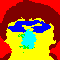

Learning rate:  0.0001728
Loss = tensor(1.4304, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4267, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  114


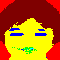

Learning rate:  0.0001728
Loss = tensor(1.4353, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4223, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4181, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4145, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  114


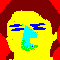

Learning rate:  0.0001728
Loss = tensor(1.4030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  114


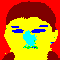

Learning rate:  0.0001728
Loss = tensor(1.4085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4498, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  115


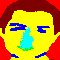

Learning rate:  0.0001728
Loss = tensor(1.4610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3918, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4490, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4628, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  115


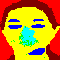

Learning rate:  0.0001728
Loss = tensor(1.4075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4452, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  115


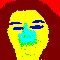

Learning rate:  0.0001728
Loss = tensor(1.4147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  116


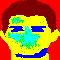

Learning rate:  0.0001728
Loss = tensor(1.4276, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4366, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  116


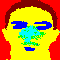

Learning rate:  0.0001728
Loss = tensor(1.4198, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4300, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4469, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  116


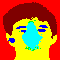

Learning rate:  0.0001728
Loss = tensor(1.4135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  117


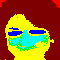

Learning rate:  0.0001728
Loss = tensor(1.4254, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3891, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4574, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4486, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4400, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  117


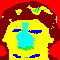

Learning rate:  0.0001728
Loss = tensor(1.4548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  117


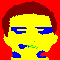

Learning rate:  0.0001728
Loss = tensor(1.4043, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  118


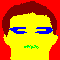

Learning rate:  0.0001728
Loss = tensor(1.4159, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4106, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  118


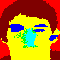

Learning rate:  0.0001728
Loss = tensor(1.4383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  118


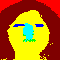

Learning rate:  0.0001728
Loss = tensor(1.4077, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  119


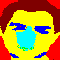

Learning rate:  0.0001728
Loss = tensor(1.3944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4461, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  119


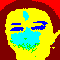

Learning rate:  0.0001728
Loss = tensor(1.4411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4385, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  119


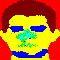

Learning rate:  0.0001728
Loss = tensor(1.4514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4628, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  120


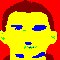

Learning rate:  0.0001728
Loss = tensor(1.4783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4406, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4294, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4053, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  120


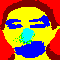

Learning rate:  0.0001728
Loss = tensor(1.4794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4600, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4171, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  120


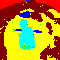

Learning rate:  0.0001728
Loss = tensor(1.4106, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4188, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  121


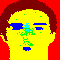

Learning rate:  0.0001728
Loss = tensor(1.4768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4022, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3885, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  121


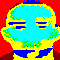

Learning rate:  0.0001728
Loss = tensor(1.5039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3957, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4357, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4302, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4054, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  121


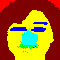

Learning rate:  0.0001728
Loss = tensor(1.4135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4107, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  122


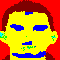

Learning rate:  0.0001728
Loss = tensor(1.4058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4188, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4586, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  122


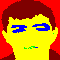

Learning rate:  0.0001728
Loss = tensor(1.4287, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4193, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  122


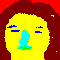

Learning rate:  0.0001728
Loss = tensor(1.4359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4511, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  123


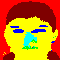

Learning rate:  0.0001728
Loss = tensor(1.4017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4095, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4192, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  123


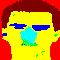

Learning rate:  0.0001728
Loss = tensor(1.4026, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4540, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  123


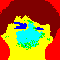

Learning rate:  0.0001728
Loss = tensor(1.4379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  124


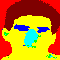

Learning rate:  0.0001728
Loss = tensor(1.4248, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4295, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4586, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4185, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  124


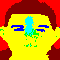

Learning rate:  0.0001728
Loss = tensor(1.4795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4276, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  124


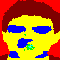

Learning rate:  0.0001728
Loss = tensor(1.4252, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  125


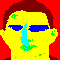

Learning rate:  0.0001728
Loss = tensor(1.4217, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4305, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4350, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  125


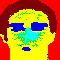

Learning rate:  0.0001728
Loss = tensor(1.4123, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4224, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  125


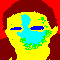

Learning rate:  0.0001728
Loss = tensor(1.4701, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4291, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  126


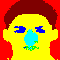

Learning rate:  0.0001728
Loss = tensor(1.4638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4453, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4256, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  126


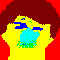

Learning rate:  0.0001728
Loss = tensor(1.4400, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4196, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4035, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3965, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  126


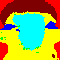

Learning rate:  0.0001728
Loss = tensor(1.4329, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4416, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  127


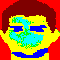

Learning rate:  0.0001728
Loss = tensor(1.3899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4699, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  127


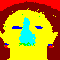

Learning rate:  0.0001728
Loss = tensor(1.4584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  127


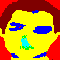

Learning rate:  0.0001728
Loss = tensor(1.4867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  128


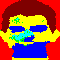

Learning rate:  0.0001728
Loss = tensor(1.4763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5035, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4186, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4068, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  128


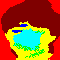

Learning rate:  0.0001728
Loss = tensor(1.3962, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4009, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4689, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  128


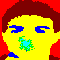

Learning rate:  0.0001728
Loss = tensor(1.4455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4354, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  129


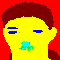

Learning rate:  0.0001728
Loss = tensor(1.4712, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  129


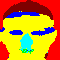

Learning rate:  0.0001728
Loss = tensor(1.4534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4055, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4074, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4674, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  129


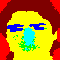

Learning rate:  0.0001728
Loss = tensor(1.4161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4123, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  130


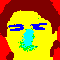

Learning rate:  0.0001728
Loss = tensor(1.4119, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4250, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  130


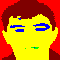

Learning rate:  0.0001728
Loss = tensor(1.5087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4207, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  130


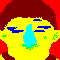

Learning rate:  0.0001728
Loss = tensor(1.4005, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3852, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  131


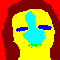

Learning rate:  0.0001728
Loss = tensor(1.4133, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4121, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  131


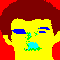

Learning rate:  0.0001728
Loss = tensor(1.4107, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4158, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4393, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4286, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  131


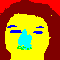

Learning rate:  0.0001728
Loss = tensor(1.3846, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  132


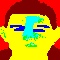

Learning rate:  0.0001728
Loss = tensor(1.3874, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4182, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4400, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  132


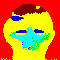

Learning rate:  0.0001728
Loss = tensor(1.4212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4215, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4287, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5126, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4125, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  132


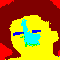

Learning rate:  0.0001728
Loss = tensor(1.4227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4586, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  133


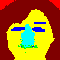

Learning rate:  0.0001728
Loss = tensor(1.4250, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4081, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4150, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  133


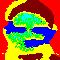

Learning rate:  0.0001728
Loss = tensor(1.4482, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4369, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4254, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  133


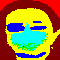

Learning rate:  0.0001728
Loss = tensor(1.4130, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  134


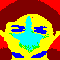

Learning rate:  0.0001728
Loss = tensor(1.4625, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3983, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4340, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  134


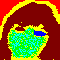

Learning rate:  0.0001728
Loss = tensor(1.4963, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4529, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  134


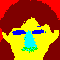

Learning rate:  0.0001728
Loss = tensor(1.4431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4151, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  135


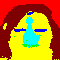

Learning rate:  0.0001728
Loss = tensor(1.4563, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4162, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4046, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  135


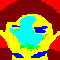

Learning rate:  0.0001728
Loss = tensor(1.4641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4292, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4103, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4304, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  135


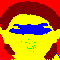

Learning rate:  0.0001728
Loss = tensor(1.3900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  136


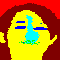

Learning rate:  0.0001728
Loss = tensor(1.3731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4139, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5281, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4377, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4224, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  136


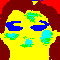

Learning rate:  0.0001728
Loss = tensor(1.4267, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4138, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3832, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4091, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4366, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  136


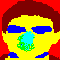

Learning rate:  0.0001728
Loss = tensor(1.4213, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  137


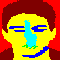

Learning rate:  0.0001728
Loss = tensor(1.4245, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  137


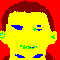

Learning rate:  0.0001728
Loss = tensor(1.4458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3952, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4118, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4357, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  137


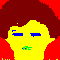

Learning rate:  0.0001728
Loss = tensor(1.4429, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4415, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  138


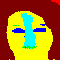

Learning rate:  0.0001728
Loss = tensor(1.3978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4305, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4054, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4020, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4446, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  138


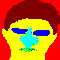

Learning rate:  0.0001728
Loss = tensor(1.4018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3908, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4563, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4322, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  138


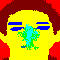

Learning rate:  0.0001728
Loss = tensor(1.4204, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4086, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  139


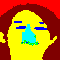

Learning rate:  0.0001728
Loss = tensor(1.4150, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4248, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  139


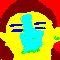

Learning rate:  0.0001728
Loss = tensor(1.4307, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4337, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4214, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  139


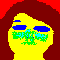

Learning rate:  0.0001728
Loss = tensor(1.4331, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4249, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  140


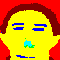

Learning rate:  0.0001728
Loss = tensor(1.3899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4223, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4326, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4045, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  140


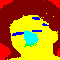

Learning rate:  0.0001728
Loss = tensor(1.4366, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4317, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4131, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  140


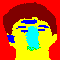

Learning rate:  0.0001728
Loss = tensor(1.4263, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4301, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  141


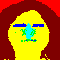

Learning rate:  0.0001728
Loss = tensor(1.4829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4368, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4160, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  141


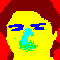

Learning rate:  0.0001728
Loss = tensor(1.4112, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4469, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4400, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  141


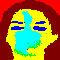

Learning rate:  0.0001728
Loss = tensor(1.4017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  142


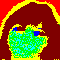

Learning rate:  0.0001728
Loss = tensor(1.4980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  142


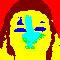

Learning rate:  0.0001728
Loss = tensor(1.4177, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4252, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4291, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  142


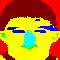

Learning rate:  0.0001728
Loss = tensor(1.3713, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  143


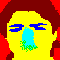

Learning rate:  0.0001728
Loss = tensor(1.4786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4011, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  143


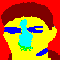

Learning rate:  0.0001728
Loss = tensor(1.3734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4121, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4021, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  143


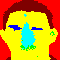

Learning rate:  0.0001728
Loss = tensor(1.4170, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  144


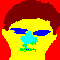

Learning rate:  0.0001728
Loss = tensor(1.4255, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4188, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4272, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3995, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  144


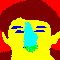

Learning rate:  0.0001728
Loss = tensor(1.4232, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4270, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  144


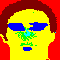

Learning rate:  0.0001728
Loss = tensor(1.3962, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4281, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  145


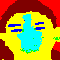

Learning rate:  0.0001728
Loss = tensor(1.4015, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4349, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4772, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4077, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  145


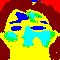

Learning rate:  0.0001728
Loss = tensor(1.4187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3955, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4071, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4029, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  145


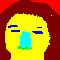

Learning rate:  0.0001728
Loss = tensor(1.4513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4208, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  146


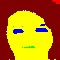

Learning rate:  0.0001728
Loss = tensor(1.4369, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4012, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  146


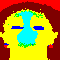

Learning rate:  0.0001728
Loss = tensor(1.3938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4031, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  146


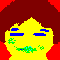

Learning rate:  0.0001728
Loss = tensor(1.4213, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4354, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  147


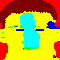

Learning rate:  0.0001728
Loss = tensor(1.4101, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4233, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  147


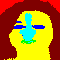

Learning rate:  0.0001728
Loss = tensor(1.4186, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3982, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4051, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  147


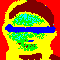

Learning rate:  0.0001728
Loss = tensor(1.4679, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  148


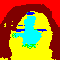

Learning rate:  0.0001728
Loss = tensor(1.4203, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4176, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4105, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3751, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  148


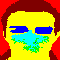

Learning rate:  0.0001728
Loss = tensor(1.4031, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4265, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4394, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  148


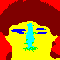

Learning rate:  0.0001728
Loss = tensor(1.3808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  149


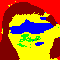

Learning rate:  0.0001728
Loss = tensor(1.4081, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4242, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4291, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  149


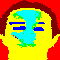

Learning rate:  0.0001728
Loss = tensor(1.4052, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4145, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  149


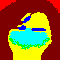

Learning rate:  0.0001728
Loss = tensor(1.4438, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4139, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  150


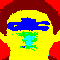

Learning rate:  0.0001728
Loss = tensor(1.4423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4131, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  150


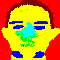

Learning rate:  0.0001728
Loss = tensor(1.4737, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4279, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4232, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4180, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4219, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  150


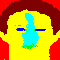

Learning rate:  0.0001728
Loss = tensor(1.4010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4382, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  151


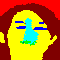

Learning rate:  0.0001728
Loss = tensor(1.4254, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4163, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4079, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  151


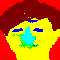

Learning rate:  0.0001728
Loss = tensor(1.4098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4236, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4238, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4241, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  151


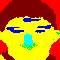

Learning rate:  0.0001728
Loss = tensor(1.4155, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  152


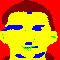

Learning rate:  0.0001728
Loss = tensor(1.4193, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4034, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4067, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4432, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  152


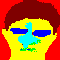

Learning rate:  0.0001728
Loss = tensor(1.4750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4093, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4067, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4279, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4661, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  152


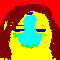

Learning rate:  0.0001728
Loss = tensor(1.3737, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3892, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  153


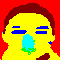

Learning rate:  0.0001728
Loss = tensor(1.4455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4014, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4395, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4361, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  153


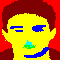

Learning rate:  0.0001728
Loss = tensor(1.4111, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4615, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4509, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4314, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  153


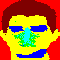

Learning rate:  0.0001728
Loss = tensor(1.4444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4299, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  154


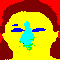

Learning rate:  0.0001728
Loss = tensor(1.3598, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4454, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  154


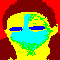

Learning rate:  0.0001728
Loss = tensor(1.4144, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3906, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4506, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  154


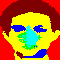

Learning rate:  0.0001728
Loss = tensor(1.3863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  155


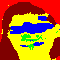

Learning rate:  0.0001728
Loss = tensor(1.4070, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  155


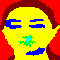

Learning rate:  0.0001728
Loss = tensor(1.3780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4296, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4268, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  155


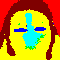

Learning rate:  0.0001728
Loss = tensor(1.4463, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  156


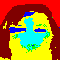

Learning rate:  0.0001728
Loss = tensor(1.3869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4348, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  156


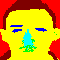

Learning rate:  0.0001728
Loss = tensor(1.4042, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  156


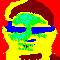

Learning rate:  0.0001728
Loss = tensor(1.4168, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  157


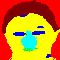

Learning rate:  0.0001728
Loss = tensor(1.3723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4269, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  157


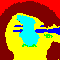

Learning rate:  0.0001728
Loss = tensor(1.4226, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4127, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4324, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4207, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  157


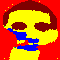

Learning rate:  0.0001728
Loss = tensor(1.3921, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4264, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  158


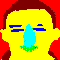

Learning rate:  0.0001728
Loss = tensor(1.4039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4124, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  158


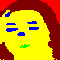

Learning rate:  0.0001728
Loss = tensor(1.3919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4034, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4193, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4309, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  158


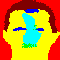

Learning rate:  0.0001728
Loss = tensor(1.4529, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  159


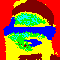

Learning rate:  0.0001728
Loss = tensor(1.3933, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4417, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  159


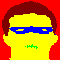

Learning rate:  0.0001728
Loss = tensor(1.3889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4275, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  159


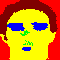

Learning rate:  0.0001728
Loss = tensor(1.3832, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3976, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  160


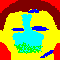

Learning rate:  0.0001728
Loss = tensor(1.4518, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  160


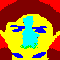

Learning rate:  0.0001728
Loss = tensor(1.4264, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4497, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3918, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4182, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  160


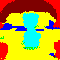

Learning rate:  0.0001728
Loss = tensor(1.3762, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4228, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  161


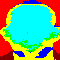

Learning rate:  0.0001728
Loss = tensor(1.3936, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4482, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4221, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4067, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  161


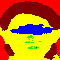

Learning rate:  0.0001728
Loss = tensor(1.4523, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3998, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4793, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  161


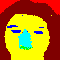

Learning rate:  0.0001728
Loss = tensor(1.4066, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  162


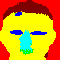

Learning rate:  0.0001728
Loss = tensor(1.4545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4336, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4149, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  162


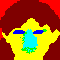

Learning rate:  0.0001728
Loss = tensor(1.4384, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4080, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4378, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4078, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4265, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  162


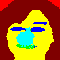

Learning rate:  0.0001728
Loss = tensor(1.3985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4003, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  163


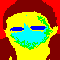

Learning rate:  0.0001728
Loss = tensor(1.4970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4106, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4169, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4353, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4285, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  163


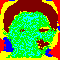

Learning rate:  0.0001728
Loss = tensor(1.3939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4078, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4092, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  163


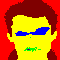

Learning rate:  0.0001728
Loss = tensor(1.3937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  164


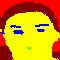

Learning rate:  0.0001728
Loss = tensor(1.3928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3887, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4268, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  164


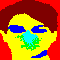

Learning rate:  0.0001728
Loss = tensor(1.4417, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3983, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4242, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  164


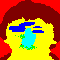

Learning rate:  0.0001728
Loss = tensor(1.4037, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4154, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  165


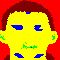

Learning rate:  0.0001728
Loss = tensor(1.4153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4022, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4397, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4287, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  165


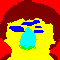

Learning rate:  0.0001728
Loss = tensor(1.4051, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3979, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5021, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4006, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4393, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  165


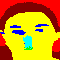

Learning rate:  0.0001728
Loss = tensor(1.3860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4298, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  166


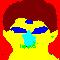

Learning rate:  0.0001728
Loss = tensor(1.4207, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3747, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4191, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  166


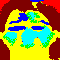

Learning rate:  0.0001728
Loss = tensor(1.4693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4171, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4230, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  166


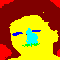

Learning rate:  0.0001728
Loss = tensor(1.4058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  167


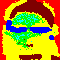

Learning rate:  0.0001728
Loss = tensor(1.4446, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4352, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4337, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  167


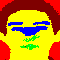

Learning rate:  0.0001728
Loss = tensor(1.4307, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4299, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4330, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4259, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  167


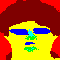

Learning rate:  0.0001728
Loss = tensor(1.4626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  168


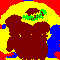

Learning rate:  0.0001728
Loss = tensor(1.4317, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4757, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4342, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  168


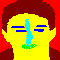

Learning rate:  0.0001728
Loss = tensor(1.3773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4004, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4291, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  168


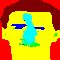

Learning rate:  0.0001728
Loss = tensor(1.3823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  169


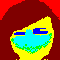

Learning rate:  0.0001728
Loss = tensor(1.4103, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4267, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4104, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4158, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  169


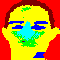

Learning rate:  0.0001728
Loss = tensor(1.4806, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4375, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4120, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4141, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  169


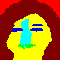

Learning rate:  0.0001728
Loss = tensor(1.4218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4370, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  170


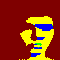

Learning rate:  0.0001728
Loss = tensor(1.4549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4282, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3796, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4160, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  170


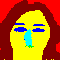

Learning rate:  0.0001728
Loss = tensor(1.4271, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4049, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4053, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4198, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  170


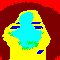

Learning rate:  0.0001728
Loss = tensor(1.4089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4346, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  171


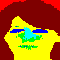

Learning rate:  0.0001728
Loss = tensor(1.3962, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4290, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4086, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4298, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  171


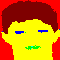

Learning rate:  0.0001728
Loss = tensor(1.4386, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  171


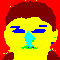

Learning rate:  0.0001728
Loss = tensor(1.4091, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4368, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  172


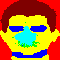

Learning rate:  0.0001728
Loss = tensor(1.3875, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4295, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  172


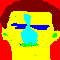

Learning rate:  0.0001728
Loss = tensor(1.3820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4047, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  172


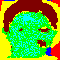

Learning rate:  0.0001728
Loss = tensor(1.4399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  173


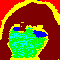

Learning rate:  0.0001728
Loss = tensor(1.4222, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4271, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4152, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  173


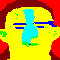

Learning rate:  0.0001728
Loss = tensor(1.4987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4124, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  173


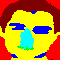

Learning rate:  0.0001728
Loss = tensor(1.4367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4172, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  174


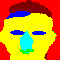

Learning rate:  0.0001728
Loss = tensor(1.3932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4137, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4137, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4269, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4050, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  174


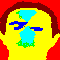

Learning rate:  0.0001728
Loss = tensor(1.4161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4014, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  174


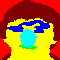

Learning rate:  0.0001728
Loss = tensor(1.4109, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  175


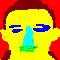

Learning rate:  0.0001728
Loss = tensor(1.3916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  175


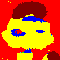

Learning rate:  0.0001728
Loss = tensor(1.3905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4759, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  175


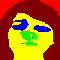

Learning rate:  0.0001728
Loss = tensor(1.4440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  176


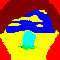

Learning rate:  0.0001728
Loss = tensor(1.4314, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4170, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4129, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  176


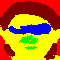

Learning rate:  0.0001728
Loss = tensor(1.4263, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4120, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4193, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  176


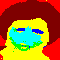

Learning rate:  0.0001728
Loss = tensor(1.4490, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4032, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  177


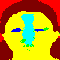

Learning rate:  0.0001728
Loss = tensor(1.4324, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4464, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  177


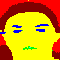

Learning rate:  0.0001728
Loss = tensor(1.4249, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4190, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  177


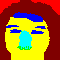

Learning rate:  0.0001728
Loss = tensor(1.4197, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4366, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  178


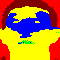

Learning rate:  0.0001728
Loss = tensor(1.4515, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3979, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4294, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4526, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  178


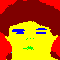

Learning rate:  0.0001728
Loss = tensor(1.4498, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4263, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  178


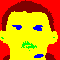

Learning rate:  0.0001728
Loss = tensor(1.3934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4076, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  179


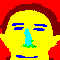

Learning rate:  0.0001728
Loss = tensor(1.4428, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4048, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  179


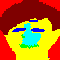

Learning rate:  0.0001728
Loss = tensor(1.4382, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4139, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4190, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  179


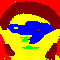

Learning rate:  0.0001728
Loss = tensor(1.4157, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3963, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  180


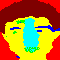

Learning rate:  0.0001728
Loss = tensor(1.4019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4279, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4378, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  180


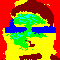

Learning rate:  0.0001728
Loss = tensor(1.4923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4116, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4384, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  180


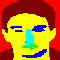

Learning rate:  0.0001728
Loss = tensor(1.4385, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4243, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  181


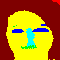

Learning rate:  0.0001728
Loss = tensor(1.4338, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4387, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4172, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4517, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  181


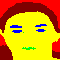

Learning rate:  0.0001728
Loss = tensor(1.4415, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4007, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3775, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3749, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3816, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  181


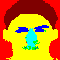

Learning rate:  0.0001728
Loss = tensor(1.3966, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  182


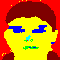

Learning rate:  0.0001728
Loss = tensor(1.4803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3979, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4180, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4247, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  182


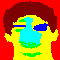

Learning rate:  0.0001728
Loss = tensor(1.3687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4272, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4285, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4183, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  182


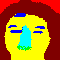

Learning rate:  0.0001728
Loss = tensor(1.3796, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4343, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  183


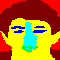

Learning rate:  0.0001728
Loss = tensor(1.4043, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4158, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4165, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4316, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  183


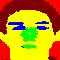

Learning rate:  0.0001728
Loss = tensor(1.4027, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3975, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4243, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  183


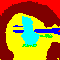

Learning rate:  0.0001728
Loss = tensor(1.3697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  184


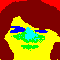

Learning rate:  0.0001728
Loss = tensor(1.4575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4461, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4326, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  184


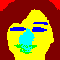

Learning rate:  0.0001728
Loss = tensor(1.4707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4177, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4207, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4313, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  184


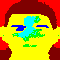

Learning rate:  0.0001728
Loss = tensor(1.4186, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4417, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  185


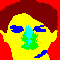

Learning rate:  0.0001728
Loss = tensor(1.4207, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4195, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4632, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  185


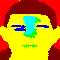

Learning rate:  0.0001728
Loss = tensor(1.3963, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4106, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4256, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4096, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4775, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  185


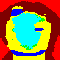

Learning rate:  0.0001728
Loss = tensor(1.4162, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5144, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  186


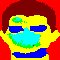

Learning rate:  0.0001728
Loss = tensor(1.3928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4208, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3986, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5119, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  186


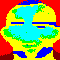

Learning rate:  0.0001728
Loss = tensor(1.4622, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4329, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  186


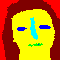

Learning rate:  0.0001728
Loss = tensor(1.4145, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4328, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  187


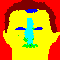

Learning rate:  0.0001728
Loss = tensor(1.4227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4062, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4326, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4595, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4628, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  187


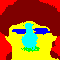

Learning rate:  0.0001728
Loss = tensor(1.4411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4404, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4046, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  187


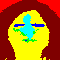

Learning rate:  0.0001728
Loss = tensor(1.3772, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4317, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  188


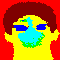

Learning rate:  0.0001728
Loss = tensor(1.4278, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4307, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4445, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  188


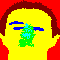

Learning rate:  0.0001728
Loss = tensor(1.5246, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4163, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4157, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  188


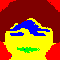

Learning rate:  0.0001728
Loss = tensor(1.4490, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  189


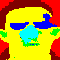

Learning rate:  0.0001728
Loss = tensor(1.4075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4276, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3845, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4250, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  189


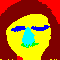

Learning rate:  0.0001728
Loss = tensor(1.4119, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3963, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4340, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  189


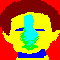

Learning rate:  0.0001728
Loss = tensor(1.4150, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4233, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  190


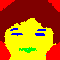

Learning rate:  0.0001728
Loss = tensor(1.4211, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3861, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3998, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  190


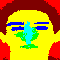

Learning rate:  0.0001728
Loss = tensor(1.4067, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4197, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4232, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4342, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  190


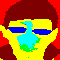

Learning rate:  0.0001728
Loss = tensor(1.4224, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4119, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  191


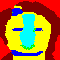

Learning rate:  0.0001728
Loss = tensor(1.3902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4574, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4072, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  191


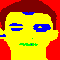

Learning rate:  0.0001728
Loss = tensor(1.3909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4107, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4264, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4269, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  191


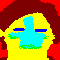

Learning rate:  0.0001728
Loss = tensor(1.4262, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3981, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  192


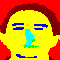

Learning rate:  0.0001728
Loss = tensor(1.4773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4113, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4328, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  192


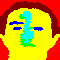

Learning rate:  0.0001728
Loss = tensor(1.4156, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3996, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4406, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4077, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  192


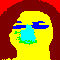

Learning rate:  0.0001728
Loss = tensor(1.4382, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4164, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  193


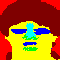

Learning rate:  0.0001728
Loss = tensor(1.4295, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4421, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4432, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4494, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  193


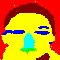

Learning rate:  0.0001728
Loss = tensor(1.4231, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3953, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  193


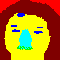

Learning rate:  0.0001728
Loss = tensor(1.4182, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  194


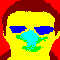

Learning rate:  0.0001728
Loss = tensor(1.4266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4421, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4146, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  194


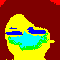

Learning rate:  0.0001728
Loss = tensor(1.4166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4640, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3881, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4060, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  194


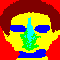

Learning rate:  0.0001728
Loss = tensor(1.3738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  195


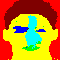

Learning rate:  0.0001728
Loss = tensor(1.4301, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  195


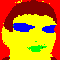

Learning rate:  0.0001728
Loss = tensor(1.3990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4114, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4342, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  195


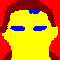

Learning rate:  0.0001728
Loss = tensor(1.4240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3749, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  196


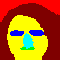

Learning rate:  0.0001728
Loss = tensor(1.4134, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4069, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  196


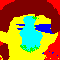

Learning rate:  0.0001728
Loss = tensor(1.4413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4368, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  196


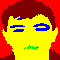

Learning rate:  0.0001728
Loss = tensor(1.4795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  197


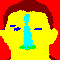

Learning rate:  0.0001728
Loss = tensor(1.4229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4335, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4125, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  197


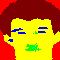

Learning rate:  0.0001728
Loss = tensor(1.4663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4044, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4032, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  197


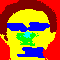

Learning rate:  0.0001728
Loss = tensor(1.4032, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4121, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  198


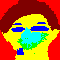

Learning rate:  0.0001728
Loss = tensor(1.4288, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3994, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3751, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4343, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  198


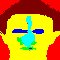

Learning rate:  0.0001728
Loss = tensor(1.4169, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3979, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5004, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  198


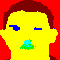

Learning rate:  0.0001728
Loss = tensor(1.4458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4090, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  199


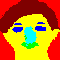

Learning rate:  0.0001728
Loss = tensor(1.4416, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4333, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4226, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  199


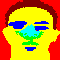

Learning rate:  0.0001728
Loss = tensor(1.4153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4364, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3908, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  199


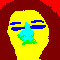

Learning rate:  0.0001728
Loss = tensor(1.4206, device='cuda:0', grad_fn=<NllLoss2DBackward>)


In [27]:
for epoch in range(epochs):
    i = 0
    last = False
    
    if epoch == epochs-1:
        last = True
        
    for batch in train_loader_CE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)
            
        b = get_rgb(x)
        out = loss2(b, targets.detach().long())
        print("Loss =", out)
        loss_ce.append(float(out))
        c = b.detach().clone()
        
        if (i % 5 == 0):
            print("EPOCH: ", epoch)
            display(ts(max_rgb(c)[0]))
            print("Learning rate: ", scheduler.get_last_lr()[0])
            del c
        i += 1
        
        optimizer.zero_grad()
        out.backward()
        optimizer.step()
        
    scheduler.step()

In [26]:
torch.save(model, 'misc_figures/learnable.pth')

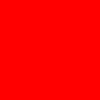

In [26]:
from IPython.display import display, Image
Image('final.gif')

torch.Size([70, 70, 4])


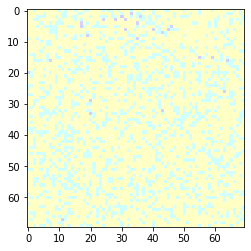

In [94]:
# Show certainty of pixels

a = max_rgba(b[0]).detach().clone().to('cpu')
plt.imshow(a.transpose(1,2).transpose(0,2))
plt.show()

In [107]:
# Save final iterations as gif

epoch_new = [ts(max_rgb(i)[0]) for i in epoch_history]
epoch_new[0].save('anitest.gif',
               save_all=True,
               append_images=epoch_new[1:],
               duration=1000,
               loop=0)

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mutual_info_score 
from sklearn.metrics import ConfusionMatrixDisplay

# DICE Score
def dice(pred, truth, epsilon=1e-6):
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()

    x = confusion_matrix(pred, target)
    
    FP = x.sum(axis=0) - np.diag(x)
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    FP = np.sum(FP)
    FN = np.sum(FN)
    TP = np.sum(TP)
    TN = np.sum(TN)
    
    d5 = 2*TP+FN+FP
    if d5 == 0:
        d5 = epsilon
    dice = 2*TP/d5
    
    return dice   

# Precision, Recall, Accuracy and Specificity Score
def pras(pred, truth):
    
    # Convert to format for confusion matrix
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()

    x = confusion_matrix(pred, target)

    # Calculate FP, FN, TP, TN
    FP = x.sum(axis=0) - np.diag(x)
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    # Set the denominators and deal with 0 denominators
    d1 = TP+FP
    d1[np.where(d1==0)] = -1
    d2 = TP+FN
    d2[np.where(d2==0)] = -1
    d3 = TP+TN+FP+FN
    d3[np.where(d3==0)] = -1
    d4 = TN+FP
    d4[np.where(d4==0)] = -1

    # Calculate and return scores
    precision = TP/d1
    recall = TP/d2
    accuracy = (TP+TN)/d3
    specificity = TN/d4
    
    return precision, recall, accuracy, specificity

# Recall Score
def overall_pras(pred, truth):
    
    # Convert to format for confusion matrix
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()
    
    x = confusion_matrix(pred, target)

    FP = x.sum(axis=0) - np.diag(x)  
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    # Sum the values for overall values
    FP = np.sum(FP)
    FN = np.sum(FN)
    TP = np.sum(TP)
    TN = np.sum(TN)
    
    # Set the denominators and deal with 0 denominators
    d1 = TP+FP
    d2 = TP+FN
    d3 = TP+TN+FP+FN
    d4 = TN+FP
    
    # Calculate and return scores and deal with potential 0 denominators
    if d1 > 0:
        precision = TP/d1
    else:
        precision = -1
        
    if d2 > 0:
        recall = TP/d2
    else:
        recall = -1
    
    if d3 > 0:
        accuracy = (TP+TN)/d3
    else:
        d3 = -1
        
    if d4 > 0:
        specificity = TN/d4
    else:
        specificity = -1
    
    return precision, recall, accuracy, specificity

# Mutual Information
def mi(pred, target):
    print(pred.squeeze().shape)
    print(target.flatten().shape)
    return mutual_info_score(pred.flatten().cpu(), target.flatten().cpu())

def get_confusion(pred, target):
    pred = pred.view(-1).cpu()
    target = target.view(-1).cpu()
    x = confusion_matrix(pred.cpu(), target.cpu())
    return x

def print_confusion(conf):
    xt = ["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"]
    sns.set(font_scale=1.4, rc={'figure.figsize':(11.7,8.27)}) 
    sns.heatmap(conf, annot=True, annot_kws={"size": 16}, fmt='g', xticklabels=xt, yticklabels=xt)
    plt.savefig("confusion.png")

In [26]:
# Empty lists for precision, recall, accuracy, specificity, DICE

po_list = []
ro_list = []
ao_list = []
so_list = []

p_list = []
r_list = []
a_list = []
s_list = []

dice_list = []
mi_list = []

Loss = tensor(1.5026, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


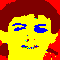

1.502629041671753
Loss = tensor(1.4379, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


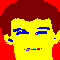

1.437887191772461
Loss = tensor(1.4396, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


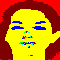

1.439571738243103
Loss = tensor(1.4139, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


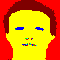

1.4139163494110107
Loss = tensor(1.4512, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


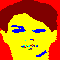

1.4511669874191284
Loss = tensor(1.4150, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


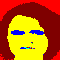

1.415017008781433
Loss = tensor(1.4720, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


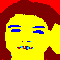

1.472037672996521
Loss = tensor(1.7380, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


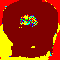

1.7379792928695679
Loss = tensor(1.7510, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


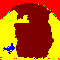

1.7510093450546265
Loss = tensor(1.4343, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


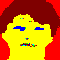

1.4342882633209229
Loss = tensor(1.4810, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


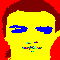

1.481019377708435
Loss = tensor(1.4532, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


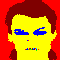

1.4532376527786255
Loss = tensor(1.4750, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


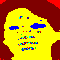

1.475045084953308
Loss = tensor(1.4302, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


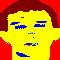

1.4301788806915283
Loss = tensor(1.4582, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


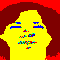

1.458184003829956
Loss = tensor(1.5727, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


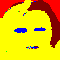

1.5726631879806519
Loss = tensor(1.4286, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


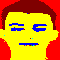

1.4286024570465088
Loss = tensor(1.4614, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


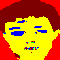

1.4613633155822754
Loss = tensor(1.4639, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


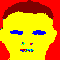

1.463870644569397
Loss = tensor(1.3986, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


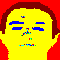

1.3986308574676514
Loss = tensor(1.4887, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


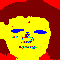

1.4887045621871948
Loss = tensor(1.4716, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


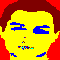

1.471634864807129
Loss = tensor(1.4242, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


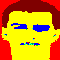

1.4242277145385742
Loss = tensor(1.4863, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


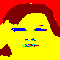

1.4862816333770752
Loss = tensor(1.4941, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


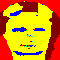

1.4940820932388306
Loss = tensor(1.4564, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


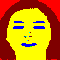

1.456355333328247
Loss = tensor(1.4522, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


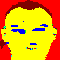

1.4522364139556885
Loss = tensor(1.4514, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


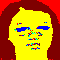

1.451393961906433
Loss = tensor(1.4687, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


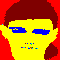

1.4687440395355225
Loss = tensor(1.4678, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


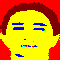

1.467756748199463


In [27]:
# Inference and test loss
loss_test_ce = []
batch_size=1
conf_running = torch.zeros(6,6)

with torch.no_grad():
    for batch in test_loader_CE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)

        b = get_rgb(x)
        pred = torch.argmax(b, dim=1)
        out = loss2(b, targets.detach().long())
        print("Loss =", out)
        loss_test_ce.append(float(out))
        c = b.detach().clone()
        
        target = targets.detach().long()
        
        # Log metrics
        p,r,a,s = overall_pras(pred, target)
        po_list.append(p)
        ro_list.append(r)
        ao_list.append(a)
        so_list.append(s)
        
        d = dice(pred, target)
        dice_list.append(d.item())
        
        m = mi(pred, target)
        mi_list.append(m)
        
        p,r,a,s = pras(pred, target)
        p_list.append(p)
        r_list.append(r)
        a_list.append(a)
        s_list.append(s)
        
        conf_running += get_confusion(pred, target)
        
        for i in range(batch_size):
            display(ts(max_rgb(c)[i]))
        del c
        print(float(out))

In [29]:
boxplot_p = np.array(p_list)
boxplot_r = np.array(r_list)
boxplot_a = np.array(a_list)
boxplot_s = np.array(s_list)
boxplot_mi = np.array(mi_list)

np.save('metrics/learn_p.npy', boxplot_p)
np.save('metrics/learn_r.npy', boxplot_r)
np.save('metrics/learn_a.npy', boxplot_a)
np.save('metrics/learn_s.npy', boxplot_s)
np.save('metrics/learn_m.npy', boxplot_mi)
np.save('metrics/learn_dice.npy', dice_list)

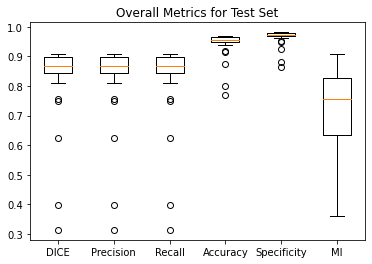

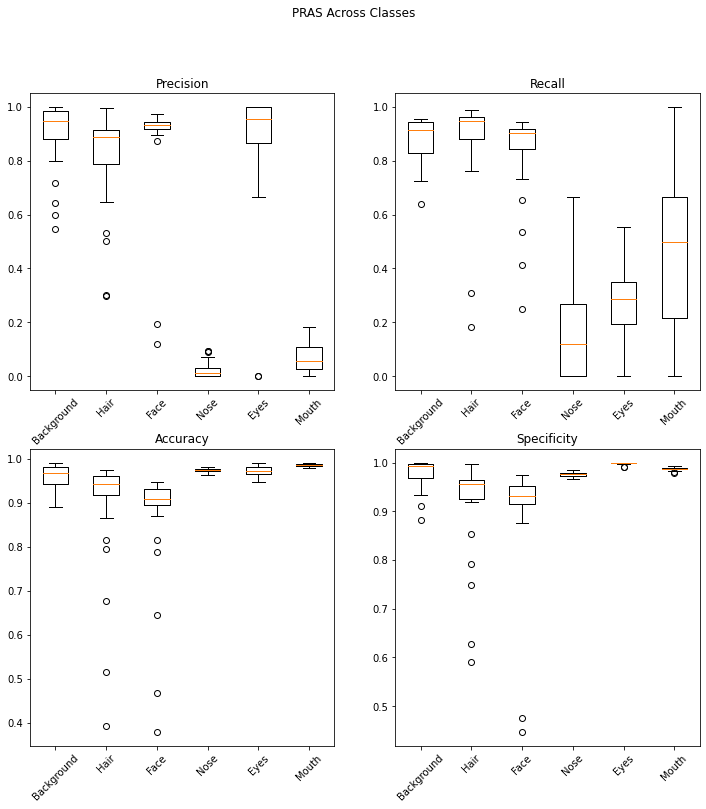

In [30]:
pras_overall_list = [dice_list, po_list, ro_list, ao_list, so_list, mi_list]
#sns.boxplot(x=np.array(pras_overall_list), y=np.array([1,2,3,4]))
plt.boxplot(pras_overall_list)
plt.xticks([1,2,3,4,5,6],["DICE", "Precision", "Recall", "Accuracy", "Specificity", "MI"])
plt.title("Overall Metrics for Test Set")
plt.savefig("1LearnPras.png")


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
ax1.boxplot(boxplot_p)
ax1.set_title("Precision")
ax1.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax2.boxplot(boxplot_r)
ax2.set_title("Recall")
ax2.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax3.boxplot(boxplot_a)
ax3.set_title("Accuracy")
ax3.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax4.boxplot(boxplot_s)
ax4.set_title("Specificity")
ax4.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

fig.set_figwidth(12)
fig.set_figheight(12)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
fig.suptitle('PRAS Across Classes')

plt.savefig("pras/1LearnPrasClass.png")

In [31]:
np.save('1dice_learn.npy', dice_list)

In [4]:
learn = np.load('dice_learn.npy')
collab = np.load('dice_collabAlt.npy')
global1 = np.load('dice_global.npy')
naive = np.load('dice_naive.npy')
nbhd = np.load('dice_nbhd.npy')
stoch = np.load('dice_stoch.npy')

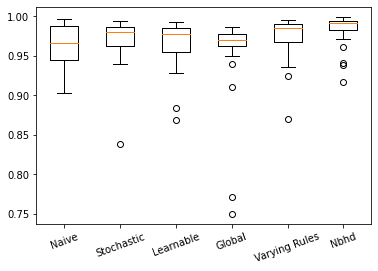

In [18]:
dice_scores = [naive, stoch, learn, global1, collab, nbhd]
plt.boxplot(dice_scores)
plt.xticks([1,2,3,4,5,6],["Naive", "Stochastic", "Learnable", "Global", "Varying Rules", "Nbhd"], rotation=20)
plt.savefig("overall_dice.png")

In [20]:
mean_dice_scores = np.mean(np.array(dice_scores), axis=1)
mean_dice_scores

array([0.96375079, 0.96999221, 0.96604569, 0.95440691, 0.97352972,
       0.98331245])